In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!unzip

In [ ]:
# By Default Cloned under /content/
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 15672, done.
remote: Total 15672 (delta 0), reused 0 (delta 0), pack-reused 15672
Receiving objects: 100% (15672/15672), 14.44 MiB | 16.78 MiB/s, done.
Resolving deltas: 100% (10741/10741), done.


In [ ]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.2/585.2 kB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 26.9 MB/s eta 0:00:00


In [ ]:
%cd yolov5
from yolov5 import utils
display = utils.notebook_init()  # checks Pytorch and GPU used
!pip install -r requirements.txt

YOLOv5 🚀 v7.0-167-g5deff14 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)


Setup complete ✅ (12 CPUs, 83.5 GB RAM, 23.5/166.8 GB disk)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


In [ ]:
#@title Setup Training YAML File
number_of_classes = 5 #@param {type:"integer"}
with open('new_train_yaml', 'w+') as file:
    file.write(
        f"""
        # parameters
        nc: {number_of_classes}  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

In [ ]:
#@title Setup Dataset Configuration (Data.yaml)
train_data_dir = "/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/train" #@param {type:"string"}
val_data_dir = "/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/valid" #@param {type:"string"}
class_names = ['boat', 'car', 'dock', 'jetski', 'lift'] #@param {type:"raw"}
with open('new_data_yaml', 'w+') as file:
    file.write(
        f"""
        train: {train_data_dir}
        val: {val_data_dir}

        nc: {number_of_classes}
        names: {class_names}
        """
    )

In [ ]:
!python /content/yolov5/train.py --img 416 --batch 16 --epochs 200 --data /content/yolov5/new_data_yaml --cfg /content/yolov5/new_train_yaml

train: weights=yolov5s.pt, cfg=/content/yolov5/new_train_yaml, data=/content/yolov5/new_data_yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-167-g5deff14 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, a

In [ ]:
!ls /content/yolov5/runs/train/exp

confusion_matrix.png				    results.png
events.out.tfevents.1684152313.1cb2964a4301.2109.0  train_batch0.jpg
F1_curve.png					    train_batch1.jpg
hyp.yaml					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
opt.yaml					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


In [ ]:
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100256.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/101527.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/101058.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100256.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-167-g5deff14 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
image 1/1 /content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100256.jpg: 320x416 2 boats, 91.8ms
Speed: 0.6ms pre-process, 91.8ms inference, 96.4ms NMS

In [ ]:
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100005.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100011.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100028.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100005.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-167-g5deff14 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
new_train_yaml summary: 182 layers, 7257306 parameters, 0 gradients
image 1/1 /content/gdrive/MyDrive/42028/AT2/Object_Detection/yolo/test/images/100005.jpg: 320x416 1 boat, 1 lift, 89.9ms
Speed: 0.5ms pre-process, 89.9ms inference, 91.

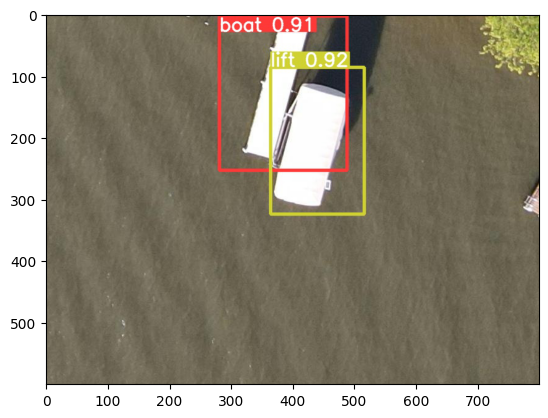

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp6/100005.jpg')
plt.imshow(image)

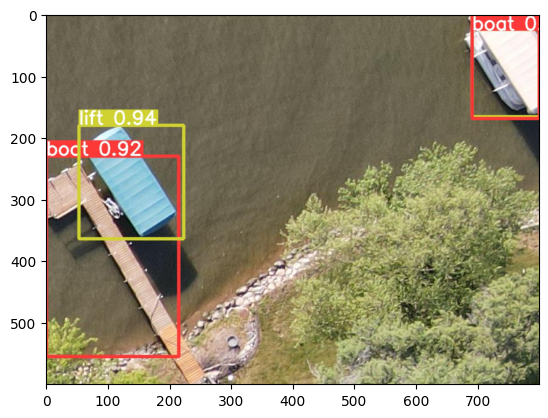

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp11/100011.jpg')
plt.imshow(image)

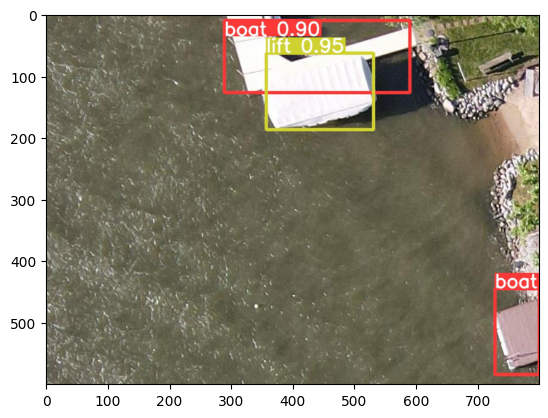

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp12/100028.jpg')
plt.imshow(image)

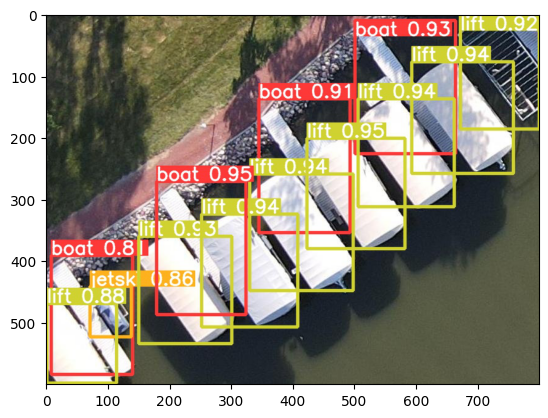

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp8/101527.jpg')
plt.imshow(image)

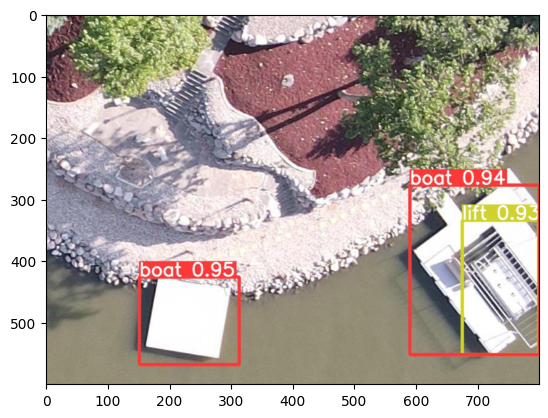

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp9/101058.jpg')
plt.imshow(image)

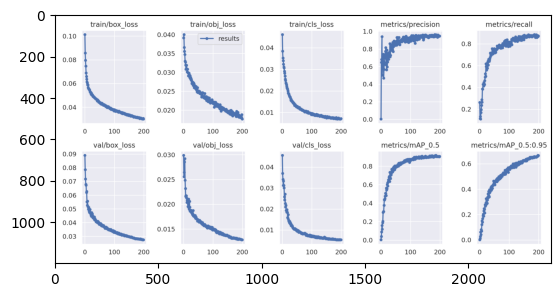

In [ ]:
image = Image.open('/content/yolov5/runs/train/exp/results.png') # Change 'exp' to the last in the train directory
plt.imshow(image)

In [ ]:
#[OPTIONAL] Alternate way of ploting the curves from CSV file
from utils.plots import plot_results 
# Change the path to the last exp under train folder.
plot_results('/content/yolov5/runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the saved image file
img = mpimg.imread('/content/yolov5/runs/train/exp/results.png')

# Display the image
plt.imshow(img)
plt.show()
